In [1]:
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import cm
from matplotlib import pyplot as plt
from bancs import BANCS, DrawFunctions

In [2]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

## Parabolic 2 reliability problem

In [3]:
g = ot.SymbolicFunction(["x1", "x2"], ["(x1 - x2) ^ 2 - 8 * (x1 + x2 - 5)"])

In [4]:
#X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2, ot.GumbelCopula(3.))
X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
threshold = 0.
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
# Reference computed using CMC with subset size N=1e7
pf_ref = 0.0001315399999999369

In [5]:
#initialNumberOfCall = g.getEvaluationCallsNumber()
#Nref = int(1e7)
#experiment = ot.MonteCarloExperiment()
#algoMC = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)
#algoMC.setMaximumCoefficientOfVariation(0.001)
#algoMC.setMaximumOuterSampling(Nref)
#algoMC.setBlockSize(10)
#algoMC.run()
#numberOfFunctionEvaluations = (g.getEvaluationCallsNumber() - initialNumberOfCall)
#print("{:.3e}".format(numberOfFunctionEvaluations))
#print(algoMC.getResult().getProbabilityEstimate())

## BANCS : Bernstein Adaptive Nonparametric Conditional Sampling

In [6]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
greys = mpl.colormaps['Greys_r']
faded_greys = ListedColormap(greys(np.linspace(0.4, 1, 128)))

Quantiles = [27.06038532 14.55954652  6.07188765 -0.49986106]
Proba EBC = 1.19e-04
Relative error = 9.51%


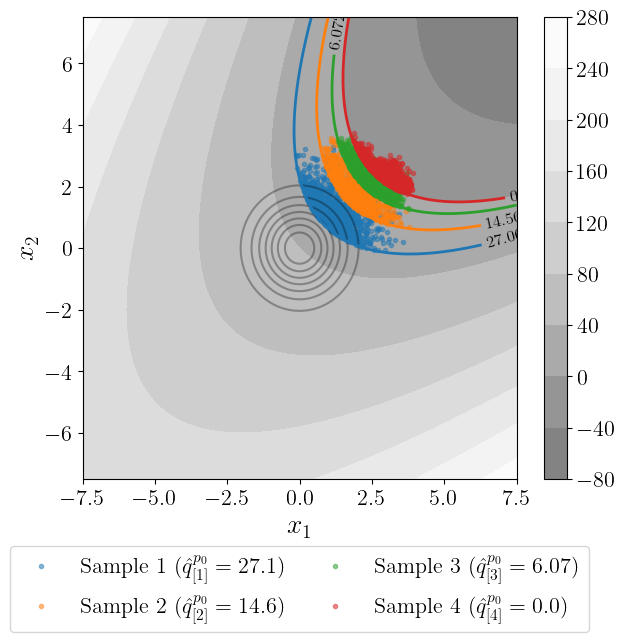

In [7]:
N = int(1e4)
bancs = BANCS(failure_event, N=N, M=22, p0=0.1)
quantiles = bancs.run()
pf = bancs.compute_pf()
print("Quantiles =", quantiles)
print("Proba EBC = {:.2e}".format(pf))
print("Relative error = {:.2%}".format(np.abs(pf - pf_ref) / pf_ref))
fig = bancs.draw_2D_BANCS(colorbar=faded_greys)
plt.savefig("figures/bancs_parabolic2.pdf", bbox_inches='tight')
plt.savefig("figures/bancs_parabolic2.jpg", bbox_inches='tight', dpi=300);

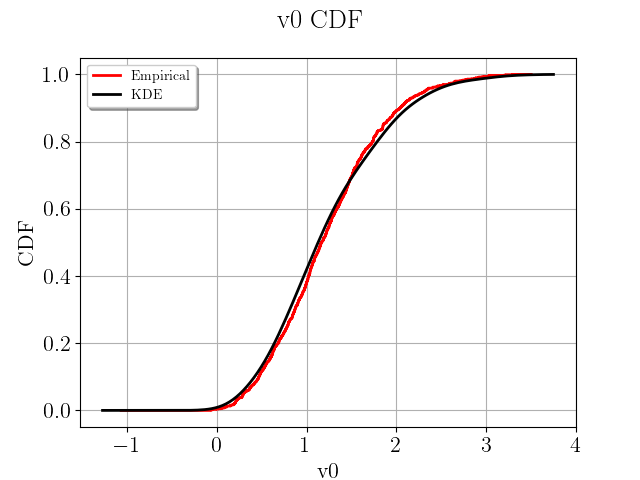

In [8]:
# Marginals goodness of fit
subset_idx = 1
xi = 0

sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==subset_idx-1)]["X"+str(xi+1)].values.reshape(-1, 1) 
empirical = ot.UserDefined(sample)
fitted_marginal = bancs.conditional_distributions[subset_idx].getMarginal(xi)
graph = empirical.drawCDF()
graph.add(fitted_marginal.drawCDF())
graph.setLegends(['Empirical', 'KDE', 'KDE mixture'])
graph.setColors(['red','black', 'blue', 'green'])
graph

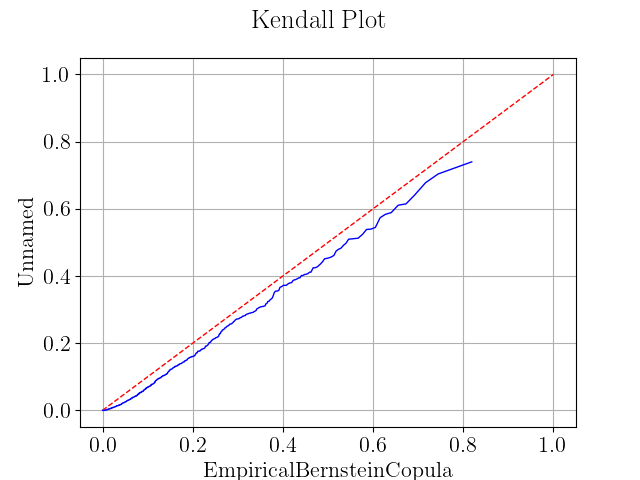

In [9]:
# Empirical Bernstein copula goodness of fit
subset_idx = 3
fitted_copula = bancs.conditional_distributions[subset_idx].getCopula()
sample = bancs.df[(bancs.df["Failed"]==1) & (bancs.df["Subset"]==subset_idx-1)][['X0', 'X1']].values
#sample.setName('Subset sample $\mathbf{X}_N^{2} | g(\mathbf{X}_N^{2}) < \hat{q_N^{2}}$')
kendallPlot = ot.VisualTest.DrawKendallPlot(sample, fitted_copula)
kendallPlot